## Importing libraries

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import math
import cplex 
import ipopt
import matplotlib.pyplot as plt

## Defining functions for various Strategies

#### Buy and Hold Strategy

In [2]:
# Complete the following functions
def strat_buy_and_hold(x_init, cash_init, mu, Q, cur_prices):
    x_optimal = x_init
    cash_optimal = cash_init
    return x_optimal, cash_optimal

#### Equally weighted Strategy

In [3]:
def strat_equally_weighted(x_init, cash_init, mu, Q, cur_prices):
    initial_value = np.dot(x_init,cur_prices) + cash_init #Calculating Initial value of stock
    value_each_stock = initial_value/20 #Calculating value of each stock
    qty_each_stock = value_each_stock/cur_prices #Calculating Initial quantity for each stock
 
    # The first if condition will run only in the first period
    if cash_init == 0:
        x_optimal = np.ceil(qty_each_stock) #Rounding-up the number of each stock
        trans_chrg = np.dot(abs(x_optimal - x_init),cur_prices)*0.005 #Calculating the transaction charge
        cash_optimal = initial_value - np.dot(x_optimal,cur_prices) - trans_chrg #Calculating value of cash optimal
        #As cash in an account cannot be less than zero thus giving the condition for that and then recomputing the quantity of stock for each stock
        if cash_optimal < 0: 
            while cash_optimal < 0:
                
                for i in range(20):
                    if x_optimal[np.argsort(cur_prices)[i]]>0: #Stock with the minimum price and non zero stocks
                        x_optimal[np.argsort(cur_prices)[i]] -= 1 #Decreasing the quantity by one
                        cash_optimal += trans_chrg #Adding the previous transaction cost to the cash optimal
                        trans_chrg = np.dot(abs(x_optimal - x_init),cur_prices)*0.005 #Calculating the new transaction charge
                        cash_optimal += cur_prices[np.argsort(cur_prices)[i]] - trans_chrg #Removing the new transaction cost but adding the price of the stock that was removed
                        break
                    
                    else:
                        continue
    #When cash optimal is non zero return the below value and we will calculate the cash optimal in the for loops                    
    else:
        x_optimal = np.ceil(qty_each_stock)
        cash_optimal = initial_value - np.dot(x_optimal,cur_prices)
    return x_optimal, cash_optimal

#### Minimum Variance Optimization Equation

\begin{equation}
\begin{array}{rl}
\displaystyle \min_{w} & w^TQw \\
{\rm s.t.} & \sum_i w_i = 1\\
& w \geq 0
\end{array}
\end{equation}

In [4]:
def strat_min_variance(x_init, cash_init, mu, Q, cur_prices):
    initial_value = np.dot(x_init,cur_prices) + cash_init #Calculating Initial value of stock
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    n = len(x_init)
    c  = [0.0] * n
    lb = [0.0] * n
    ub = [np.inf] * n
    A = []
    for k in range(n):
        A.append([[0],[1.0]]) #Creating the contraint matrix
    cpx.linear_constraints.add(rhs=[1.0], senses="E") #Equality constraint for the constraint
    var_names = ["w_%s" % i for i in range(1,n+1)]
    cpx.variables.add(obj = c, ub = ub, columns = A, names = var_names)
    Qmat = [[list(range(n)), list(2*Q[k,:])] for k in range(n)] #Formulating the objective function
    cpx.objective.set_quadratic(Qmat)
    alg = cpx.parameters.lpmethod.values
    cpx.parameters.qpmethod.set(alg.concurrent)
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    cpx.solve()
    weights = np.array(cpx.solution.get_values())
    value_each_stock = weights*initial_value #Calculating value of each stock
    qty_each_stock = value_each_stock/cur_prices #Calculating Initial quantity for each stock
    # The first if condition will run only in the first period
    if cash_init == 0:
        x_optimal = np.ceil(qty_each_stock) #Rounding-up the number of each stock
        trans_chrg = np.dot(abs(x_optimal - x_init),cur_prices)*0.005 #Calculating the transaction charge
        cash_optimal = initial_value - np.dot(x_optimal,cur_prices) - trans_chrg #Calculating value of cash optimal
        #As cash in an account cannot be less than zero thus giving the condition for that and then recomputing the quantity of stock for each stock
        if cash_optimal < 0:
            while cash_optimal < 0:
                
                for i in range(20):
                    if x_optimal[np.argsort(cur_prices)[i]]>0: #Stock with the minimum price and non zero stocks
                        x_optimal[np.argsort(cur_prices)[i]] -= 1 #Decreasing the quantity by one
                        cash_optimal += trans_chrg #Adding the previous transaction cost to the cash optimal
                        trans_chrg = np.dot(abs(x_optimal - x_init),cur_prices)*0.005 #Calculating the new transaction charge
                        cash_optimal += cur_prices[np.argsort(cur_prices)[i]] - trans_chrg #Removing the new transaction cost but adding the price of the stock that was removed
                        break
                    
                    else:
                        continue
    #When cash optimal is non zero return the below value and we will calculate the cash optimal in the for loops                    
    else:
        x_optimal = np.ceil(qty_each_stock)
        cash_optimal = initial_value - np.dot(x_optimal,cur_prices)
    return x_optimal, cash_optimal

#### Maximum Sharpe Optimization Equation

\begin{equation}
\begin{array}{rl}
\displaystyle \min_{y} & y^TQy \\
& w = y/k \\
{\rm s.t.} & \sum_i (u_i - r_f)y_i = 1\\
& \sum_i y_i = 1\\
& y \geq 0
\end{array}
\end{equation}

In [5]:
def strat_max_Sharpe(x_init, cash_init, mu, Q, cur_prices):
    initial_value = np.dot(x_init,cur_prices) + cash_init #Calculating Initial value of stock
    r_rf = 0.025/252 #Dividing the risk free rate by 252 as ther are 252 trading days per year
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    n = len(x_init) + 1 #Because of presence of K, n is 21 
    c  = [0.0] * n
    lb = [0.0] * n
    ub = [np.inf] * (n)
    A = []
    
    for k in range(n-1):
        A.append([[0, 1],[mu[k]-r_rf, 1.0]]) #Creating the contraint matrix
    A.append([[0,1],[0,-1.0]]) #Creating the contraint matrix
    cpx.linear_constraints.add(rhs=[1.0, 0], senses="EE") #Equality constraint for the constraint
    var_names = ["y_%s" % i for i in range(1,n+1)]
    cpx.variables.add(obj = c, ub = ub, columns = A, names = var_names)
    Qmat = [[list(range(n)), list(2*np.append(Q[k,:],0))] for k in range(n-1)] #Appending zeroes in the last column
    Qmat.append([list(range(n)), [0]*n]) #Appending zeroes in the last row
    cpx.objective.set_quadratic(Qmat)
    alg = cpx.parameters.lpmethod.values
    cpx.parameters.qpmethod.set(alg.concurrent)
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    cpx.solve()
    weights = np.array(cpx.solution.get_values()[0:20])/np.array(cpx.solution.get_values()[-1]) #W = y/K
    value_each_stock = weights*initial_value #Calculating value of each stock
    qty_each_stock = value_each_stock/cur_prices #Calculating Initial quantity for each stock
    
    # The first if condition will run only in the first period
    if cash_init == 0:
        x_optimal = np.ceil(qty_each_stock) #Rounding-up the number of each stock
        trans_chrg = np.dot(abs(x_optimal - x_init),cur_prices)*0.005 #Calculating the transaction charge
        cash_optimal = initial_value - np.dot(x_optimal,cur_prices) - trans_chrg #Calculating value of cash optimal
        #As cash in an account cannot be less than zero thus giving the condition for that and then recomputing the quantity of stock for each stock
        if cash_optimal < 0:
            while cash_optimal < 0:
                
                for i in range(20):
                    if x_optimal[np.argsort(cur_prices)[i]]>0: #Stock with the minimum price and non zero stocks
                        x_optimal[np.argsort(cur_prices)[i]] -= 1 #Decreasing the quantity by one
                        cash_optimal += trans_chrg #Adding the previous transaction cost to the cash optimal
                        trans_chrg = np.dot(abs(x_optimal - x_init),cur_prices)*0.005 #Calculating the new transaction charge
                        cash_optimal += cur_prices[np.argsort(cur_prices)[i]] - trans_chrg #Removing the new transaction cost but adding the price of the stock that was removed
                        break
                    
                    else:
                        continue
    #When cash optimal is non zero return the below value and we will calculate the cash optimal in the for loops                    
    else:
        x_optimal = np.ceil(qty_each_stock)
        cash_optimal = initial_value - np.dot(x_optimal,cur_prices)
    return x_optimal, cash_optimal

#### Equal Risk Contribution

\begin{equation}
 \begin{array}{rll}
  \displaystyle \min_{w} & \displaystyle \sum_{i=1}^n \sum_{j=1}^n \left( w_i (Qw)_i - w_j (Qw)_j \right)^2 \\
  \mbox{s.t.} & \sum_{i=1}^n w_i = 1 \\
  & w \geq 0
 \end{array}
\end{equation}

In [6]:
def strat_equal_risk_contr(x_init, cash_init, mu, Q, cur_prices):
    initial_value = np.dot(x_init,cur_prices) + cash_init
    n = len(x_init)
    w0 = [1.0/n] * n
    class erc(object):
        def __init__(self):
            pass

        def objective(self, x):
            # The callback for calculating the objective
            y = x * np.dot(Q, x)
            fval = 0
            for i in range(n):
                for j in range(i,n):
                    xij = y[i] - y[j]
                    fval = fval + xij*xij
            fval = 2*fval
            return fval

        def gradient(self, x):
            # The callback for calculating the gradient
            grad = np.zeros(n)
            y = x * np.dot(Q, x)
            RC = np.dot(Q, x)
            for i in range(n):
                for j in range(n):
                    for k in range(j+1,n):
                        if i == j:
                            grad[i] += 4*(y[j] - y[k])*(RC[j] + x[j]*Q[j, j] - x[k]*Q[k,i])
                        elif i == k:
                            grad[i] += 4*(y[j] - y[k])*(x[j]*Q[j,k] - (RC[k] + x[k]*Q[k, k]))
                        else:
                            grad[i] += 4*(y[j] - y[k])*(x[j]*Q[j, i] - x[k]*Q[k,i])
            return grad

        def constraints(self, x):
            # The callback for calculating the constraints
            return [1.0] * n

        def jacobian(self, x):
            # The callback for calculating the Jacobian
            return np.array([[1.0] * n])
            
    lb = [0.0] * n  # lower bounds on variables
    ub = [1.0] * n  # upper bounds on variables
    cl = [1]        # lower bounds on constraints
    cu = [1]        # upper bounds on constraints

    # Define IPOPT problem
    nlp = ipopt.problem(n=len(w0), m=len(cl), problem_obj=erc(), lb=lb, ub=ub, cl=cl, cu=cu)

    # Set the IPOPT options
    nlp.addOption('jac_c_constant'.encode('utf-8'), 'yes'.encode('utf-8'))
    nlp.addOption('hessian_approximation'.encode('utf-8'), 'limited-memory'.encode('utf-8'))
    nlp.addOption('mu_strategy'.encode('utf-8'), 'adaptive'.encode('utf-8'))
    nlp.addOption('tol'.encode('utf-8'), 1e-10)

    # Solve the problem
    w_erc, info = nlp.solve(w0)
    
    value_each_stock = w_erc*initial_value #Calculating value of each stock
    qty_each_stock = value_each_stock/cur_prices #Calculating Initial quantity for each stock
    # The first if condition will run only in the first period
    if cash_init == 0:
        x_optimal = np.ceil(qty_each_stock) #Rounding-up the number of each stock
        trans_chrg = np.dot(abs(x_optimal - x_init),cur_prices)*0.005 #Calculating the transaction charge
        cash_optimal = initial_value - np.dot(x_optimal,cur_prices) - trans_chrg #Calculating value of cash optimal
        #As cash in an account cannot be less than zero thus giving the condition for that and then recomputing the quantity of stock for each stock
        if cash_optimal < 0:
            while cash_optimal < 0:
                
                for i in range(20):
                    if x_optimal[np.argsort(cur_prices)[i]]>0: #Stock with the minimum price and non zero stocks
                        x_optimal[np.argsort(cur_prices)[i]] -= 1 #Decreasing the quantity by one
                        cash_optimal += trans_chrg #Adding the previous transaction cost to the cash optimal
                        trans_chrg = np.dot(abs(x_optimal - x_init),cur_prices)*0.005 #Calculating the new transaction charge
                        cash_optimal += cur_prices[np.argsort(cur_prices)[i]] - trans_chrg #Removing the new transaction cost but adding the price of the stock that was removed
                        break
                    
                    else:
                        continue
    #When cash optimal is non zero return the below value and we will calculate the cash optimal in the for loops                    
    else:
        x_optimal = np.ceil(qty_each_stock)
        cash_optimal = initial_value - np.dot(x_optimal,cur_prices)

    return x_optimal, cash_optimal

#### Leverage Equal Risk Contribution Strategy

In [7]:
def strat_lever_equal_risk_contr(x_init, cash_init, mu, Q, cur_prices):
    r_rf = 0.025/6
    initial_value = np.dot(x_init,cur_prices) + cash_init
    n = len(x_init)
    w0 = [1.0/n] * n
    class erc(object):
        def __init__(self):
            pass

        def objective(self, x):
            # The callback for calculating the objective
            y = x * np.dot(Q, x)
            fval = 0
            for i in range(n):
                for j in range(i,n):
                    xij = y[i] - y[j]
                    fval = fval + xij*xij
            fval = 2*fval
            return fval

        def gradient(self, x):
            # The callback for calculating the gradient
            grad = np.zeros(n)
            y = x * np.dot(Q, x)
            RC = np.dot(Q, x)
            for i in range(n):
                for j in range(n):
                    for k in range(j+1,n):
                        if i == j:
                            grad[i] += 4*(y[j] - y[k])*(RC[j] + x[j]*Q[j, j] - x[k]*Q[k,i])
                        elif i == k:
                            grad[i] += 4*(y[j] - y[k])*(x[j]*Q[j,k] - (RC[k] + x[k]*Q[k, k]))
                        else:
                            grad[i] += 4*(y[j] - y[k])*(x[j]*Q[j, i] - x[k]*Q[k,i])
            return grad

        def constraints(self, x):
            # The callback for calculating the constraints
            return [1.0] * n

        def jacobian(self, x):
            # The callback for calculating the Jacobian
            return np.array([[1.0] * n])
            
    lb = [0.0] * n  # lower bounds on variables
    ub = [1.0] * n  # upper bounds on variables
    cl = [1]        # lower bounds on constraints
    cu = [1]        # upper bounds on constraints

    # Define IPOPT problem
    nlp = ipopt.problem(n=len(w0), m=len(cl), problem_obj=erc(), lb=lb, ub=ub, cl=cl, cu=cu)

    # Set the IPOPT options
    nlp.addOption('jac_c_constant'.encode('utf-8'), 'yes'.encode('utf-8'))
    nlp.addOption('hessian_approximation'.encode('utf-8'), 'limited-memory'.encode('utf-8'))
    nlp.addOption('mu_strategy'.encode('utf-8'), 'adaptive'.encode('utf-8'))
    nlp.addOption('tol'.encode('utf-8'), 1e-10)

    # Solve the problem
    w_erc, info = nlp.solve(w0)
    
    value_each_stock = w_erc*initial_value #Calculating value of each stock
    qty_each_stock = value_each_stock/cur_prices #Calculating Initial quantity for each stock
    # The first if condition will run only in the first period
    if cash_init == 0:
        x_optimal = np.ceil(qty_each_stock) #Rounding-up the number of each stock
        trans_chrg = np.dot(abs(x_optimal - x_init),cur_prices)*0.005 #Calculating the transaction charge
        cash_optimal = initial_value - np.dot(x_optimal,cur_prices) - trans_chrg - r_rf*1000002.12 #Calculating value of cash optimal
        #As cash in an account cannot be less than zero thus giving the condition for that and then recomputing the quantity of stock for each stock
        if cash_optimal < 0:
            while cash_optimal < 0:
                
                for i in range(20):
                    if x_optimal[np.argsort(cur_prices)[i]]>0: #Stock with the minimum price and non zero stocks
                        x_optimal[np.argsort(cur_prices)[i]] -= 1 #Decreasing the quantity by one
                        cash_optimal += trans_chrg #Adding the previous transaction cost to the cash optimal
                        trans_chrg = np.dot(abs(x_optimal - x_init),cur_prices)*0.005 #Calculating the new transaction charge
                        cash_optimal += cur_prices[np.argsort(cur_prices)[i]] - trans_chrg #Removing the new transaction cost but adding the price of the stock that was removed
                        break
                    
                    else:
                        continue
    #When cash optimal is non zero return the below value and we will calculate the cash optimal in the for loops                    
    else:
        x_optimal = np.ceil(qty_each_stock)
        cash_optimal = initial_value - np.dot(x_optimal,cur_prices) - r_rf*1000002.12

    return x_optimal, cash_optimal

#### Robust Mean-Variance

\begin{equation}
  \begin{array}{lll}
    \min   & w^TQw       \\
    {\rm s.t.} & \begin{array}[t]{@{\hspace{0cm}}r@{\hspace{0.1cm}}c@{\hspace{0.1cm}}ll}
          \sum_{i=1}^n w_i & = & 1  \\
          \mu^T w & \geq & \varepsilon_{\rm ret} \\
          w^T \Theta w & \leq & \tilde{\varepsilon}_{\rm rob} \\
            w & \geq & 0
     \end{array}
  \end{array}
\end{equation}

In [8]:
def strat_robust_optim(x_init, cash_init, mu, Q, cur_prices):
    initial_value = np.dot(x_init,cur_prices) + cash_init
    n = len(x_init)
    w0 = [1.0/n] * n
    class erc(object):
        def __init__(self):
            pass

        def objective(self, x):
            # The callback for calculating the objective
            y = x * np.dot(Q, x)
            fval = 0
            for i in range(n):
                for j in range(i,n):
                    xij = y[i] - y[j]
                    fval = fval + xij*xij
            fval = 2*fval
            return fval

        def gradient(self, x):
            # The callback for calculating the gradient
            grad = np.zeros(n)
            y = x * np.dot(Q, x)
            RC = np.dot(Q, x)
            for i in range(n):
                for j in range(n):
                    for k in range(j+1,n):
                        if i == j:
                            grad[i] += 4*(y[j] - y[k])*(RC[j] + x[j]*Q[j, j] - x[k]*Q[k,i])
                        elif i == k:
                            grad[i] += 4*(y[j] - y[k])*(x[j]*Q[j,k] - (RC[k] + x[k]*Q[k, k]))
                        else:
                            grad[i] += 4*(y[j] - y[k])*(x[j]*Q[j, i] - x[k]*Q[k,i])
            return grad

        def constraints(self, x):
            # The callback for calculating the constraints
            return [1.0] * n

        def jacobian(self, x):
            # The callback for calculating the Jacobian
            return np.array([[1.0] * n])
            
    lb = [0.0] * n  # lower bounds on variables
    ub = [1.0] * n  # upper bounds on variables
    cl = [1]        # lower bounds on constraints
    cu = [1]        # upper bounds on constraints

    # Define IPOPT problem
    nlp = ipopt.problem(n=len(w0), m=len(cl), problem_obj=erc(), lb=lb, ub=ub, cl=cl, cu=cu)

    # Set the IPOPT options
    nlp.addOption('jac_c_constant'.encode('utf-8'), 'yes'.encode('utf-8'))
    nlp.addOption('hessian_approximation'.encode('utf-8'), 'limited-memory'.encode('utf-8'))
    nlp.addOption('mu_strategy'.encode('utf-8'), 'adaptive'.encode('utf-8'))
    nlp.addOption('tol'.encode('utf-8'), 1e-10)

    # Solve the problem
    w_erc, info = nlp.solve(w0)
    
    var_minVar = np.dot(w_erc, np.dot(Q, w_erc))
    ret_minVar = np.dot(mu, w_erc)
    var_matr = np.diag(np.diag(Q))
    rob_minVar = np.dot(w_erc, np.dot(var_matr, w_erc))
    rob_init = np.dot(w0, np.dot(var_matr, w0))

    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    n = len(x_init)
    c  = [0.0] * n
    lb = [0.0] * n
    ub = [np.inf] * n
    A = []
    for k in range(n):
        A.append([[0,1],[1.0,mu[k]]])
        
    var_names = ["w_%s" % i for i in range(1,n+1)]
    cpx.linear_constraints.add(rhs=[1.0,ret_minVar], senses="EG")
    cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A, names=var_names)
    Qmat = [[list(range(n)), list(2*Q[k,:])] for k in range(n)]
    cpx.objective.set_quadratic(Qmat)
    Qcon = cplex.SparseTriple(ind1=var_names, ind2=range(n), val=np.diag(var_matr))
    cpx.quadratic_constraints.add(rhs=rob_init, quad_expr=Qcon, name="Qc")
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    cpx.solve()
    
    value_each_stock = np.array(cpx.solution.get_values())*initial_value #Calculating value of each stock
    qty_each_stock = value_each_stock/cur_prices #Calculating Initial quantity for each stock
    # The first if condition will run only in the first period
    if cash_init == 0:
        x_optimal = np.ceil(qty_each_stock) #Rounding-up the number of each stock
        trans_chrg = np.dot(abs(x_optimal - x_init),cur_prices)*0.005 #Calculating the transaction charge
        cash_optimal = initial_value - np.dot(x_optimal,cur_prices) - trans_chrg #Calculating value of cash optimal
        #As cash in an account cannot be less than zero thus giving the condition for that and then recomputing the quantity of stock for each stock
        if cash_optimal < 0:
            while cash_optimal < 0:
                
                for i in range(20):
                    if x_optimal[np.argsort(cur_prices)[i]]>0: #Stock with the minimum price and non zero stocks
                        x_optimal[np.argsort(cur_prices)[i]] -= 1 #Decreasing the quantity by one
                        cash_optimal += trans_chrg #Adding the previous transaction cost to the cash optimal
                        trans_chrg = np.dot(abs(x_optimal - x_init),cur_prices)*0.005 #Calculating the new transaction charge
                        cash_optimal += cur_prices[np.argsort(cur_prices)[i]] - trans_chrg #Removing the new transaction cost but adding the price of the stock that was removed
                        break
                    
                    else:
                        continue
    #When cash optimal is non zero return the below value and we will calculate the cash optimal in the for loops                    
    else:
        x_optimal = np.ceil(qty_each_stock)
        cash_optimal = initial_value - np.dot(x_optimal,cur_prices)

    return x_optimal, cash_optimal

In [9]:
# Input file
input_file_prices = 'Daily_closing_prices.csv'

# Read data into a dataframe
df = pd.read_csv(input_file_prices)

# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])
# Find the number of trading days in Nov-Dec 2014 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2014)[0])
cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

# Remove datapoints for year 2014
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

# Initial positions in the portfolio
init_positions = np.array([5000, 950, 2000, 0, 0, 0, 0, 2000, 3000, 1500, 0, 0, 0, 0, 0, 0, 1001, 0, 0, 0])

# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)

# Annual risk-free rate for years 2015-2016 is 2.5%
r_rf = 0.025
# Annual risk-free rate for years 2008-2009 is 4.5%
r_rf2008_2009 = 0.045

# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_Sharpe', 'strat_equal_risk_contr', 'strat_lever_equal_risk_contr', 'strat_robust_optim']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio', 'Equal Risk Contributions Portfolio', 'Leveraged Equal Risk Contributions Portfolio', 'Robust Optimization Portfolio']
# N_strat = 6  # comment this in your code
N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe, strat_equal_risk_contr, strat_lever_equal_risk_contr, strat_robust_optim]

portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
weights = np.zeros((N_strat, N_periods),  dtype=np.ndarray)


Initial portfolio value = $ 1000002.12



In [10]:
for period in range(1, N_periods+1):
    # Compute current year and month, first and last day of the period
    if dates_array[0, 0] == 15:
        cur_year  = 15 + math.floor(period/7)
    else:
        cur_year  = 2015 + math.floor(period/7)
    cur_month = 2*((period-1)%6) + 1
    day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
    day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
    print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))
   
   # Prices for the current day
    cur_prices = data_prices[day_ind_start,:]

   # Execute portfolio selection strategies
    for strategy  in range(N_strat):
        
        # Get current portfolio positions
        if period == 1:
            curr_positions = init_positions
            curr_cash = 0
            portf_value[strategy] = np.zeros((N_days, 1))
            if strategy == 5:
                curr_positions = 2 * init_positions #to go 200% long
                curr_cash = 0
                portf_value[strategy] = np.zeros((N_days, 1))
        else:
            curr_positions = x[strategy, period-2]
            curr_cash = cash[strategy, period-2] 

      # Compute strategy
        x[strategy, period-1], cash[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)
        
        # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
        # Check that cash account is >= 0
        # Check that we can buy new portfolio subject to transaction costs
        
        if period>=2: #as we already calculated the cash optimal in the first iteration thus period>=2
            trans_chrg = np.dot(abs(x[strategy, period-1] - x[strategy, period-2]),cur_prices)*0.005 #Calculating transaction charge
            cash[strategy, period-1] -= trans_chrg #Calculating the value of optimal cash

            #As cash in an account cannot be less than zero thus giving the condition for that and then recomputing the quantity of stock for each stock
            if cash[strategy, period-1] < 0:
                while cash[strategy, period-1] < 0:
                    for i in range(20):
                        if x[strategy, period-1][np.argsort(cur_prices)[i]]>0: #Stock with the minimum price and non zero stocks
                            x[strategy, period-1][np.argsort(cur_prices)[i]] -= 1 #Decreasing the quantity by one
                            cash[strategy, period-1] += trans_chrg #Adding the previous transaction cost to the cash optimal
                            trans_chrg = np.dot(abs(x[strategy, period-1] - x[strategy, period-2]),cur_prices)*0.005 #Calculating the new transaction charge
                            cash[strategy, period-1] += cur_prices[np.argsort(cur_prices)[i]] - trans_chrg #Removing the new transaction cost but adding the price of the stock that was removed
                            break

                        else:
                            continue

        weights[strategy, period-1] = x[strategy, period-1]*cur_prices/np.dot(x[strategy, period-1],cur_prices) #Calculating the weights
        
        # Compute portfolio value
        if strategy != 5:
            p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
        else:
            p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1] - 1000002.12
       
        portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
        print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy], 
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))

  # Compute expected returns and covariances for the next period
    cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
    mu = np.mean(cur_returns, axis = 0)
    Q = np.cov(cur_returns.T)


Period 1: start date 1/2/2015, end date 2/27/2015
  Strategy "Buy and Hold", value begin = $ 1000002.12, value end = $ 1043785.08
  Strategy "Equally Weighted Portfolio", value begin = $ 992887.17, value end = $ 1019430.17
  Strategy "Mininum Variance Portfolio", value begin = $ 991452.13, value end = $ 1015611.88
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 990051.93, value end = $ 1009429.26
  Strategy "Equal Risk Contributions Portfolio", value begin = $ 992763.43, value end = $ 1017881.30
  Strategy "Leveraged Equal Risk Contributions Portfolio", value begin = $ 981375.63, value end = $ 1031040.60
  Strategy "Robust Optimization Portfolio", value begin = $ 992106.67, value end = $ 1000425.35

Period 2: start date 3/2/2015, end date 4/30/2015
  Strategy "Buy and Hold", value begin = $ 1045234.09, value end = $ 1069877.19
  Strategy "Equally Weighted Portfolio", value begin = $ 1030017.14, value end = $ 1010932.83
  Strategy "Mininum Variance Portfolio", value begin 

## Plots for 2015-2016

#### Daily Portfolio Values 2015-2016

In [12]:
for i in range(N_strat):
    portf_value[i] = portf_value[i].flatten()
  
portf_value = np.array(portf_value).T

In [13]:
daily_data = pd.DataFrame(portf_value, columns = strategy_names)

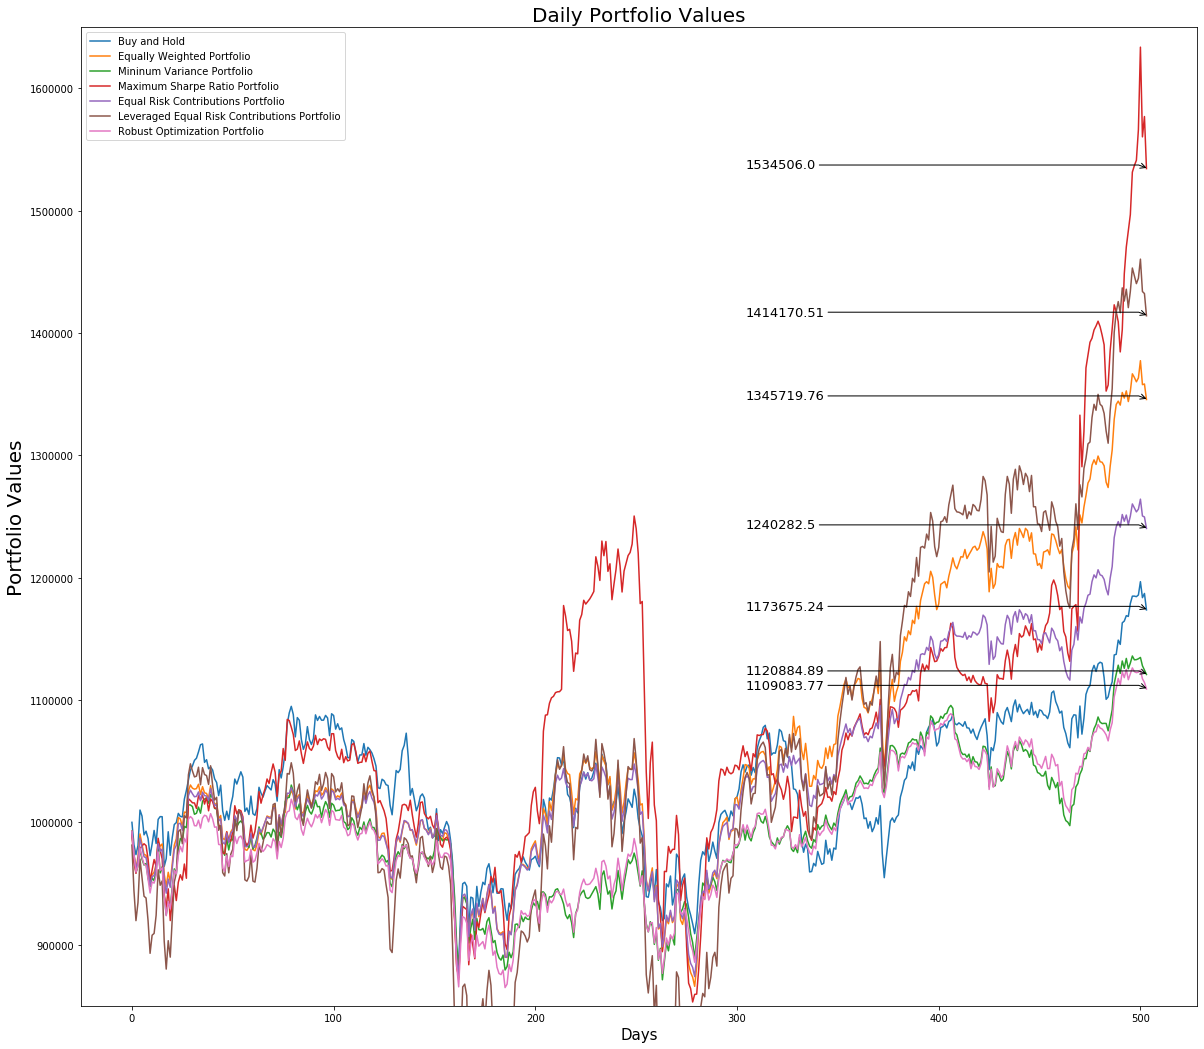

In [14]:
plt.figure(figsize=(20,18))
plt.plot(daily_data)
plt.xlabel('Days', fontsize = 15)
plt.ylabel('Portfolio Values', fontsize = 20)
plt.title('Daily Portfolio Values', fontsize = 20)
plt.ylim(850000,1650000)
plt.legend(strategy_names)
for i in range(7):
    y_final = daily_data.iloc[-1,i]
    x_pos = 504
    plt.annotate(round(y_final, 2), xy = (x_pos, y_final), xytext = (x_pos-200, y_final+50), arrowprops = dict(arrowstyle = '->', connectionstyle = 'angle, angleA = 0, angleB = -20'), fontsize = 13)
plt.show()

#### Dynamic Plot for Minimum Variance Strategy 2015-2016

In [15]:
comp_weights = []

for i in range(len(weights[2][1])):
    for j in range(len(weights[2])):
        comp_weights.append(weights[2][j][i])
        

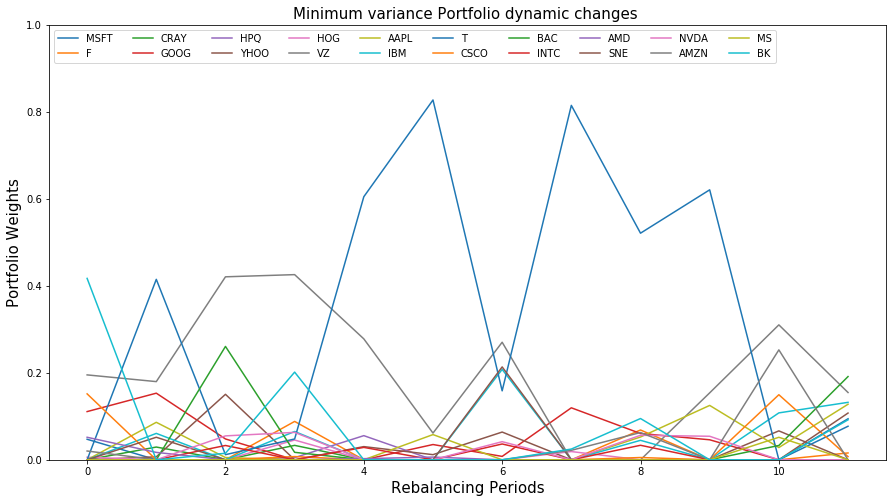

In [16]:
plt.figure(figsize=(15,8))
for i in range(20):
    plt.plot(comp_weights[i*12:(i*12)+12])
plt.xlabel('Rebalancing Periods', fontsize = 15)
plt.ylabel('Portfolio Weights', fontsize = 15)
plt.title('Minimum variance Portfolio dynamic changes ', fontsize = 15)
plt.ylim(0,1)
plt.legend(df.columns[1:],loc=2,ncol=10)
plt.show()

#### Dynamic Plot for Maximum Sharpe Ratio Strategy 2015-2016

In [17]:
comp_weights1 = []

for i in range(len(weights[2][1])):
    for j in range(len(weights[2])):
        comp_weights1.append(weights[3][j][i])
        

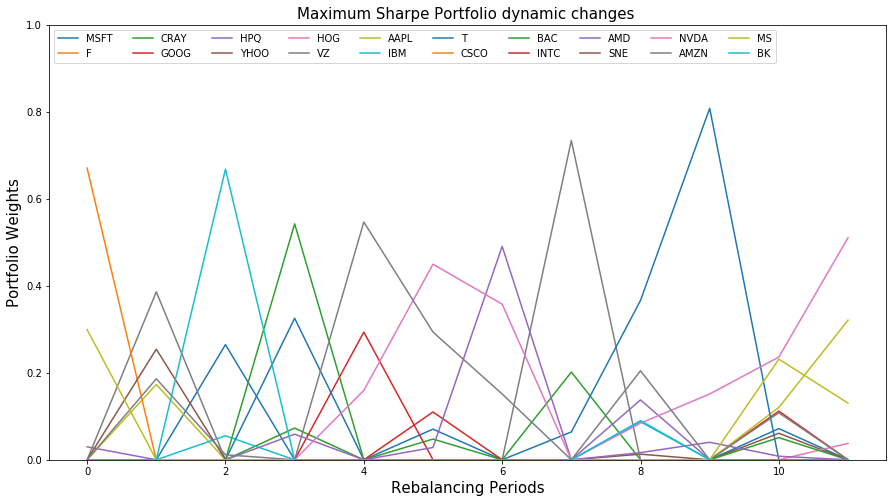

In [18]:
plt.figure(figsize=(15,8))
for i in range(20):
    plt.plot(comp_weights1[i*12:(i*12)+12])
plt.xlabel('Rebalancing Periods', fontsize = 15)
plt.ylabel('Portfolio Weights', fontsize = 15)
plt.title('Maximum Sharpe Portfolio dynamic changes ', fontsize = 15)
plt.ylim(0,1)
plt.legend(df.columns[1:],loc=2,ncol=10)
plt.show()

#### Dynamic Plot for Robust Mean Variance Strategy 2015-2016

In [19]:
comp_weights2 = []

for i in range(len(weights[2][1])):
    for j in range(len(weights[2])):
        comp_weights2.append(weights[6][j][i])
        

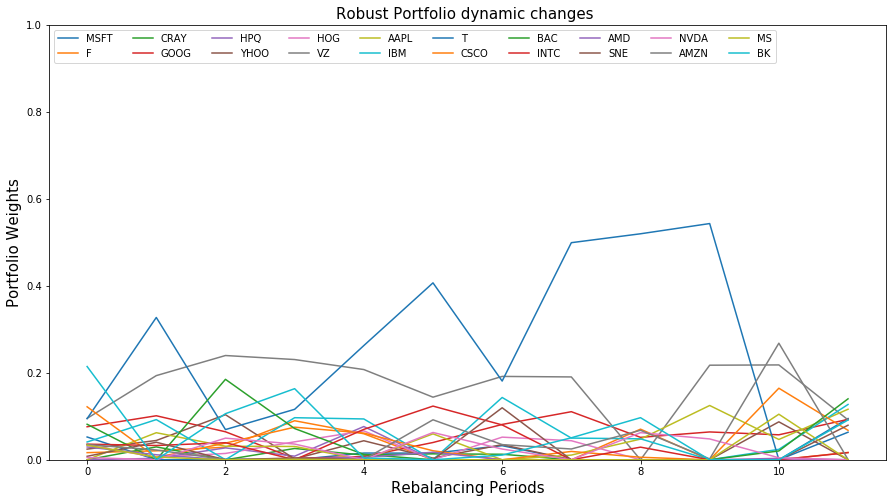

In [20]:
plt.figure(figsize=(15,8))
for i in range(20):
    plt.plot(comp_weights2[i*12:(i*12)+12])
plt.xlabel('Rebalancing Periods', fontsize = 15)
plt.ylabel('Portfolio Weights', fontsize = 15)
plt.title('Robust Portfolio dynamic changes ', fontsize = 15)
plt.ylim(0,1)
plt.legend(df.columns[1:],loc=2,ncol=10)
plt.show()

#### Daily portfolio value for the 3 new strategies 2015-2016

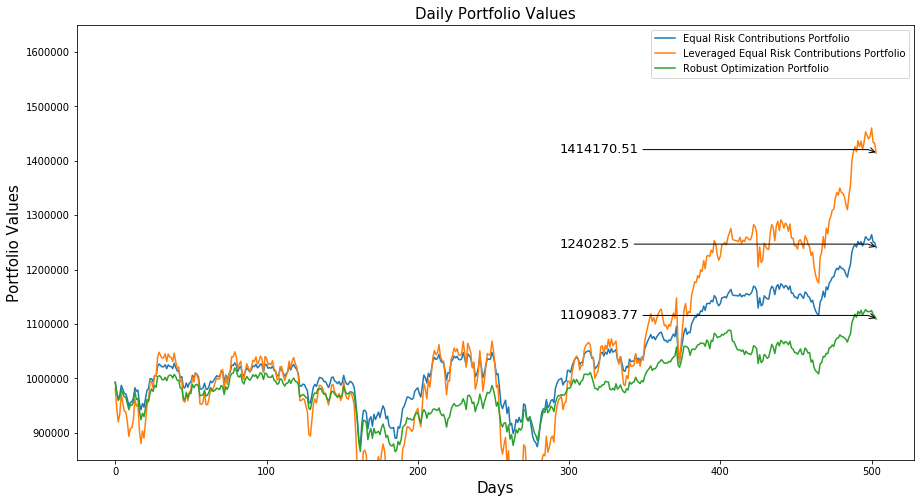

In [21]:
plt.figure(figsize=(15,8))
plt.plot(daily_data.iloc[:, 4:])
plt.xlabel('Days', fontsize = 15)
plt.ylabel('Portfolio Values', fontsize = 15)
plt.title('Daily Portfolio Values', fontsize = 15)
plt.ylim(850000,1650000)
plt.legend(strategy_names[4:])
for i in range(3):
    y_final = daily_data.iloc[-1,i+4]
    x_pos = 504
    plt.annotate(round(y_final, 2), xy = (x_pos, y_final), xytext = (x_pos-210, y_final+50), arrowprops = dict(arrowstyle = '->', connectionstyle = 'angle, angleA = 0, angleB = -20'), fontsize = 13)
plt.show()

#### Comparision of Daily portfolio value for the 3 new strategies with respect to the previous 4 strategies 2015-2016

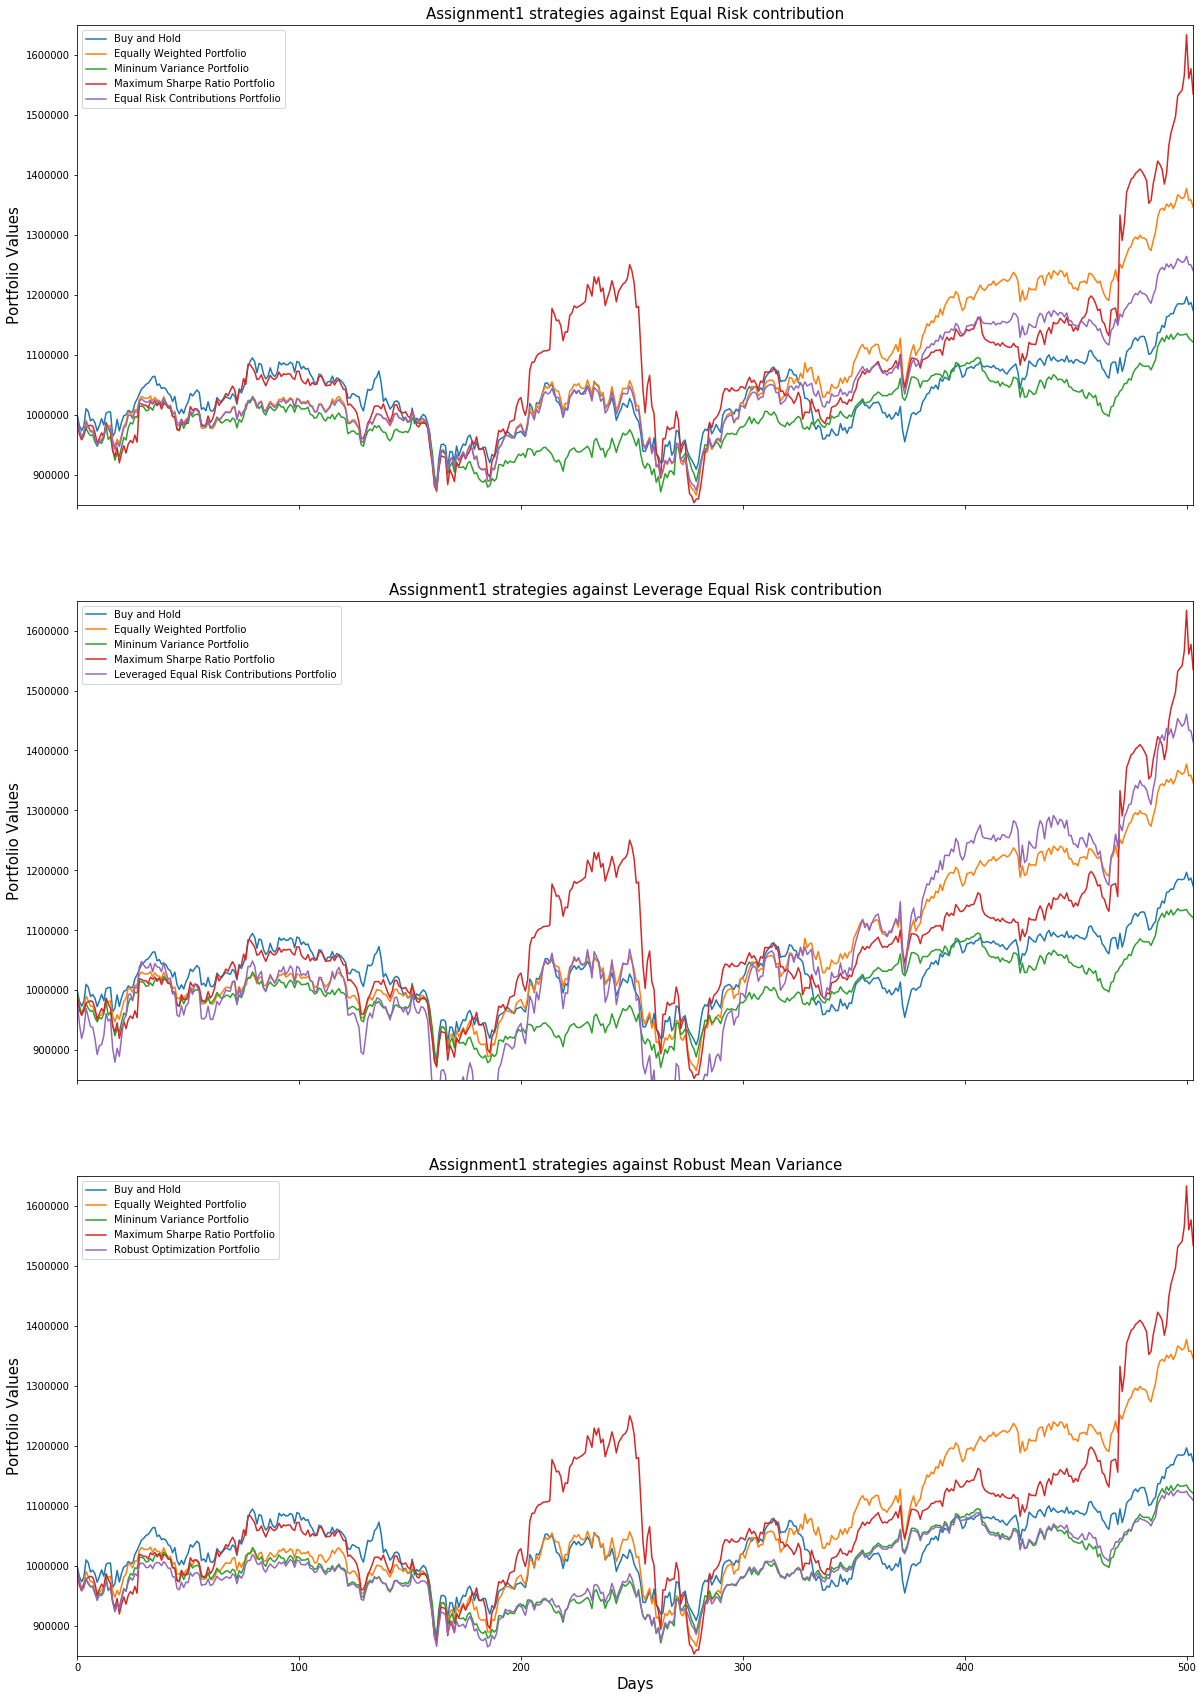

In [22]:
strat = ['Equal Risk Contributions Portfolio', 'Leveraged Equal Risk Contributions Portfolio', 'Robust Optimization Portfolio']
df1 = daily_data.iloc[:, 0:4]
dfs = []
for names in strat:
    df2  = pd.concat([df1, daily_data[names]], axis = 1, sort=False)
    dfs.append(df2)

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(20,30), sharex=True, sharey=True)
dfs[0].plot(ax=ax[0],title='Assignment1 strategies against Equal Risk contribution')
ax[0].set_ylabel('Portfolio Values', fontsize = 15)
ax[0].title.set_size(15)
dfs[1].plot(ax=ax[1],title='Assignment1 strategies against Leverage Equal Risk contribution')
ax[1].set_ylabel('Portfolio Values', fontsize = 15)
ax[1].title.set_size(15)
dfs[2].plot(ax=ax[2],title='Assignment1 strategies against Robust Mean Variance')
ax[2].set_ylabel('Portfolio Values', fontsize = 15)
ax[2].title.set_size(15)
plt.xlabel('Days', fontsize = 15)
plt.ylim(850000,1650000)
plt.show()

## 2008-2009

#### New maximum sharpe function for 2008-2009 data

In this function only the value of Risk free rate is changed

In [23]:
def strat_max_Sharpe1(x_init, cash_init, mu, Q, cur_prices):
    initial_value = np.dot(x_init,cur_prices) + cash_init #Calculating Initial value of stock
    r_rf = 0.045/252 #Dividing the risk free rate by 252 as ther are 252 trading days per year
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    n = len(x_init) + 1 #Because of presence of K, n is 21 
    c  = [0.0] * n
    lb = [0.0] * n
    ub = [np.inf] * (n)
    A = []
    
    for k in range(n-1):
        A.append([[0, 1],[mu[k]-r_rf, 1.0]]) #Creating the contraint matrix
    A.append([[0,1],[0,-1.0]]) #Creating the contraint matrix
    cpx.linear_constraints.add(rhs=[1.0, 0], senses="EE") #Equality constraint for the constraint
    var_names = ["y_%s" % i for i in range(1,n+1)]
    cpx.variables.add(obj = c, ub = ub, columns = A, names = var_names)
    Qmat = [[list(range(n)), list(2*np.append(Q[k,:],0))] for k in range(n-1)] #Appending zeroes in the last column
    Qmat.append([list(range(n)), [0]*n]) #Appending zeroes in the last row
    cpx.objective.set_quadratic(Qmat)
    alg = cpx.parameters.lpmethod.values
    cpx.parameters.qpmethod.set(alg.concurrent)
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    try:
        cpx.solve()
        weights = np.array(cpx.solution.get_values()[0:20])/np.array(cpx.solution.get_values()[-1]) #W = y/K
        value_each_stock = weights*initial_value #Calculating value of each stock
        qty_each_stock = value_each_stock/cur_prices #Calculating Initial quantity for each stock
        
    except:
        qty_each_stock = x_init
    
    
    # The first if condition will run only in the first period
    if cash_init == 0:
        x_optimal = np.ceil(qty_each_stock) #Rounding-up the number of each stock
        trans_chrg = np.dot(abs(x_optimal - x_init),cur_prices)*0.005 #Calculating the transaction charge
        cash_optimal = initial_value - np.dot(x_optimal,cur_prices) - trans_chrg #Calculating value of cash optimal
        #As cash in an account cannot be less than zero thus giving the condition for that and then recomputing the quantity of stock for each stock
        if cash_optimal < 0:
            while cash_optimal < 0:
                
                for i in range(20):
                    if x_optimal[np.argsort(cur_prices)[i]]>0: #Stock with the minimum price and non zero stocks
                        x_optimal[np.argsort(cur_prices)[i]] -= 1 #Decreasing the quantity by one
                        cash_optimal += trans_chrg #Adding the previous transaction cost to the cash optimal
                        trans_chrg = np.dot(abs(x_optimal - x_init),cur_prices)*0.005 #Calculating the new transaction charge
                        cash_optimal += cur_prices[np.argsort(cur_prices)[i]] - trans_chrg #Removing the new transaction cost but adding the price of the stock that was removed
                        break
                    
                    else:
                        continue
    #When cash optimal is non zero return the below value and we will calculate the cash optimal in the for loops                    
    else:
        x_optimal = np.ceil(qty_each_stock)
        cash_optimal = initial_value - np.dot(x_optimal,cur_prices)
    return x_optimal, cash_optimal

#### New leverage equal risk function for 2008-2009 data

In this function the value of Risk free rate is changed and while calculating the cash optimal the portfolio value of `$` 1000002.12 is changed to `$` 548247.97.

In [24]:
def strat_lever_equal_risk_contr1(x_init, cash_init, mu, Q, cur_prices):
    r_rf = 0.045/6
    initial_value = np.dot(x_init,cur_prices) + cash_init
    n = len(x_init)
    w0 = [1.0/n] * n
    class erc(object):
        def __init__(self):
            pass

        def objective(self, x):
            # The callback for calculating the objective
            y = x * np.dot(Q, x)
            fval = 0
            for i in range(n):
                for j in range(i,n):
                    xij = y[i] - y[j]
                    fval = fval + xij*xij
            fval = 2*fval
            return fval

        def gradient(self, x):
            # The callback for calculating the gradient
            grad = np.zeros(n)
            y = x * np.dot(Q, x)
            RC = np.dot(Q, x)
            for i in range(n):
                for j in range(n):
                    for k in range(j+1,n):
                        if i == j:
                            grad[i] += 4*(y[j] - y[k])*(RC[j] + x[j]*Q[j, j] - x[k]*Q[k,i])
                        elif i == k:
                            grad[i] += 4*(y[j] - y[k])*(x[j]*Q[j,k] - (RC[k] + x[k]*Q[k, k]))
                        else:
                            grad[i] += 4*(y[j] - y[k])*(x[j]*Q[j, i] - x[k]*Q[k,i])
            return grad

        def constraints(self, x):
            # The callback for calculating the constraints
            return [1.0] * n

        def jacobian(self, x):
            # The callback for calculating the Jacobian
            return np.array([[1.0] * n])
            
    lb = [0.0] * n  # lower bounds on variables
    ub = [1.0] * n  # upper bounds on variables
    cl = [1]        # lower bounds on constraints
    cu = [1]        # upper bounds on constraints

    # Define IPOPT problem
    nlp = ipopt.problem(n=len(w0), m=len(cl), problem_obj=erc(), lb=lb, ub=ub, cl=cl, cu=cu)

    # Set the IPOPT options
    nlp.addOption('jac_c_constant'.encode('utf-8'), 'yes'.encode('utf-8'))
    nlp.addOption('hessian_approximation'.encode('utf-8'), 'limited-memory'.encode('utf-8'))
    nlp.addOption('mu_strategy'.encode('utf-8'), 'adaptive'.encode('utf-8'))
    nlp.addOption('tol'.encode('utf-8'), 1e-10)

    # Solve the problem
    w_erc, info = nlp.solve(w0)
    
    value_each_stock = w_erc*initial_value #Calculating value of each stock
    qty_each_stock = value_each_stock/cur_prices #Calculating Initial quantity for each stock
    # The first if condition will run only in the first period
    if cash_init == 0:
        x_optimal = np.ceil(qty_each_stock) #Rounding-up the number of each stock
        trans_chrg = np.dot(abs(x_optimal - x_init),cur_prices)*0.005 #Calculating the transaction charge
        cash_optimal = initial_value - np.dot(x_optimal,cur_prices) - trans_chrg - r_rf*548247.97 #Calculating value of cash optimal
        #As cash in an account cannot be less than zero thus giving the condition for that and then recomputing the quantity of stock for each stock
        if cash_optimal < 0:
            while cash_optimal < 0:
                
                for i in range(20):
                    if x_optimal[np.argsort(cur_prices)[i]]>0: #Stock with the minimum price and non zero stocks
                        x_optimal[np.argsort(cur_prices)[i]] -= 1 #Decreasing the quantity by one
                        cash_optimal += trans_chrg #Adding the previous transaction cost to the cash optimal
                        trans_chrg = np.dot(abs(x_optimal - x_init),cur_prices)*0.005 #Calculating the new transaction charge
                        cash_optimal += cur_prices[np.argsort(cur_prices)[i]] - trans_chrg #Removing the new transaction cost but adding the price of the stock that was removed
                        break
                    
                    else:
                        continue
    #When cash optimal is non zero return the below value and we will calculate the cash optimal in the for loops                    
    else:
        x_optimal = np.ceil(qty_each_stock)
        cash_optimal = initial_value - np.dot(x_optimal,cur_prices) - r_rf*548247.97

    return x_optimal, cash_optimal

In [25]:
# Input file
input_file_prices20082009 = 'Daily_closing_prices20082009.csv'

# Read data into a dataframe
df = pd.read_csv(input_file_prices20082009)

# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])
# Find the number of trading days in Nov-Dec 2007 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2007)[0])
cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

# Remove datapoints for year 2014
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

# Initial positions in the portfolio
init_positions = np.array([5000, 950, 2000, 0, 0, 0, 0, 2000, 3000, 1500, 0, 0, 0, 0, 0, 0, 1001, 0, 0, 0])

# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)

# Annual risk-free rate for years 2008-2009 is 4.5%
r_rf = 0.045

# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_Sharpe', 'strat_equal_risk_contr', 'strat_lever_equal_risk_contr', 'strat_robust_optim']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio', 'Equal Risk Contributions Portfolio', 'Leveraged Equal Risk Contributions Portfolio', 'Robust Optimization Portfolio']
# N_strat = 6  # comment this in your code
N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe1, strat_equal_risk_contr, strat_lever_equal_risk_contr1, strat_robust_optim]

portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
weights = np.zeros((N_strat, N_periods),  dtype=np.ndarray)


Initial portfolio value = $ 548247.97



In [26]:
for period in range(1, N_periods+1):
    # Compute current year and month, first and last day of the period
    if dates_array[0, 0] == 8:
        cur_year  = 8 + math.floor(period/7)
    else:
        cur_year  = 2008 + math.floor(period/7)
    cur_month = 2*((period-1)%6) + 1
    day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
    day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
    print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))
   
   # Prices for the current day
    cur_prices = data_prices[day_ind_start,:]

   # Execute portfolio selection strategies
    for strategy  in range(N_strat):
        
        # Get current portfolio positions
        if period == 1:
            curr_positions = init_positions
            curr_cash = 0
            portf_value[strategy] = np.zeros((N_days, 1))
            if strategy == 5:
                curr_positions = 2 * init_positions #to go 200% long
                curr_cash = 0
                portf_value[strategy] = np.zeros((N_days, 1))
        else:
            curr_positions = x[strategy, period-2]
            curr_cash = cash[strategy, period-2] 

      # Compute strategy
        x[strategy, period-1], cash[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)
        
        # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
        # Check that cash account is >= 0
        # Check that we can buy new portfolio subject to transaction costs
        
        if period>=2: #as we already calculated the cash optimal in the first iteration thus period>=2
            trans_chrg = np.dot(abs(x[strategy, period-1] - x[strategy, period-2]),cur_prices)*0.005 #Calculating transaction charge
            cash[strategy, period-1] -= trans_chrg #Calculating the value of optimal cash

            #As cash in an account cannot be less than zero thus giving the condition for that and then recomputing the quantity of stock for each stock
            if cash[strategy, period-1] < 0:
                while cash[strategy, period-1] < 0:
                    for i in range(20):
                        if x[strategy, period-1][np.argsort(cur_prices)[i]]>0: #Stock with the minimum price and non zero stocks
                            x[strategy, period-1][np.argsort(cur_prices)[i]] -= 1 #Decreasing the quantity by one
                            cash[strategy, period-1] += trans_chrg #Adding the previous transaction cost to the cash optimal
                            trans_chrg = np.dot(abs(x[strategy, period-1] - x[strategy, period-2]),cur_prices)*0.005 #Calculating the new transaction charge
                            cash[strategy, period-1] += cur_prices[np.argsort(cur_prices)[i]] - trans_chrg #Removing the new transaction cost but adding the price of the stock that was removed
                            break

                        else:
                            continue

        weights[strategy, period-1] = x[strategy, period-1]*cur_prices/np.dot(x[strategy, period-1],cur_prices) #Calculating the weights
        
        # Compute portfolio value
        if strategy != 5:
            p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
        else:
            p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1] - 548247.97
       
        portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
        print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy], 
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))

  # Compute expected returns and covariances for the next period
    cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
    mu = np.mean(cur_returns, axis = 0)
    Q = np.cov(cur_returns.T)


Period 1: start date 1/2/2008, end date 2/29/2008
  Strategy "Buy and Hold", value begin = $ 548247.97, value end = $ 465217.72
  Strategy "Equally Weighted Portfolio", value begin = $ 544335.39, value end = $ 470262.11
  Strategy "Mininum Variance Portfolio", value begin = $ 543920.05, value end = $ 460892.25
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 542792.84, value end = $ 473578.92
  Strategy "Equal Risk Contributions Portfolio", value begin = $ 544302.88, value end = $ 471969.91
  Strategy "Leveraged Equal Risk Contributions Portfolio", value begin = $ 536265.74, value end = $ 392412.54
  Strategy "Robust Optimization Portfolio", value begin = $ 544591.17, value end = $ 471883.16

Period 2: start date 3/3/2008, end date 4/30/2008
  Strategy "Buy and Hold", value begin = $ 462553.95, value end = $ 511257.48
  Strategy "Equally Weighted Portfolio", value begin = $ 463908.61, value end = $ 510269.88
  Strategy "Mininum Variance Portfolio", value begin = $ 453661.8

CPLEX Error  1217: No solution exists.


  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 439928.35, value end = $ 437749.93
  Strategy "Equal Risk Contributions Portfolio", value begin = $ 459759.47, value end = $ 463014.64
  Strategy "Leveraged Equal Risk Contributions Portfolio", value begin = $ 355310.81, value end = $ 360929.49
  Strategy "Robust Optimization Portfolio", value begin = $ 478892.43, value end = $ 479204.21

Period 5: start date 9/2/2008, end date 10/31/2008
  Strategy "Buy and Hold", value begin = $ 478985.24, value end = $ 369998.60
  Strategy "Equally Weighted Portfolio", value begin = $ 451301.27, value end = $ 316537.66
  Strategy "Mininum Variance Portfolio", value begin = $ 486278.96, value end = $ 373801.60
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 425107.83, value end = $ 295376.07
  Strategy "Equal Risk Contributions Portfolio", value begin = $ 460680.30, value end = $ 333846.57
  Strategy "Leveraged Equal Risk Contributions Portfolio", value begin = $ 352387.71, val

In [27]:
# pd.DataFrame(cash)

## Plots for 2008-2009

#### Daily Portfolio Values 2008-2009

In [28]:
for i in range(N_strat):
    portf_value[i] = portf_value[i].flatten()
  
portf_value = np.array(portf_value).T
daily_data = pd.DataFrame(portf_value, columns = strategy_names)

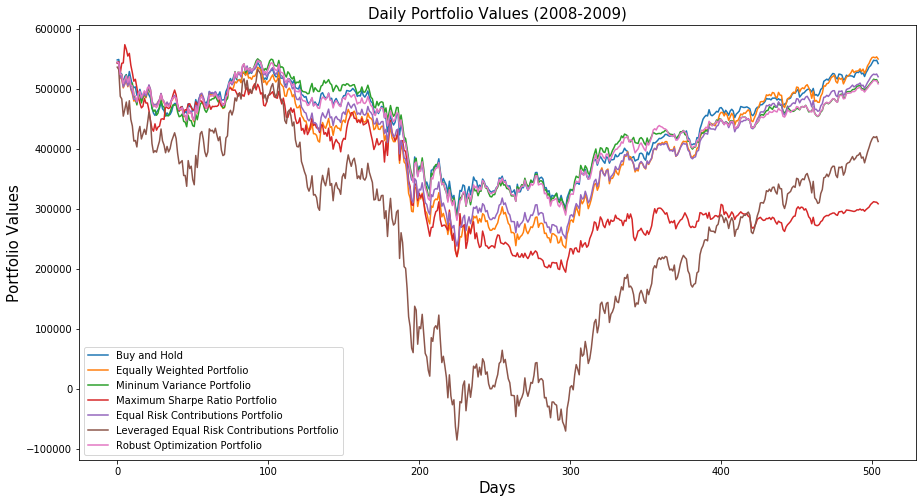

In [29]:
plt.figure(figsize=(15,8))
plt.plot(daily_data)
plt.xlabel('Days', fontsize = 15)
plt.ylabel('Portfolio Values', fontsize = 15)
plt.title('Daily Portfolio Values (2008-2009)', fontsize = 15)
plt.legend(strategy_names, loc = 3)
plt.show()

#### Dynamic Plot for Minimum Variance Strategy 2008-2009

In [30]:
comp_weights = []

for i in range(len(weights[2][1])):
    for j in range(len(weights[2])):
        comp_weights.append(weights[2][j][i])
        

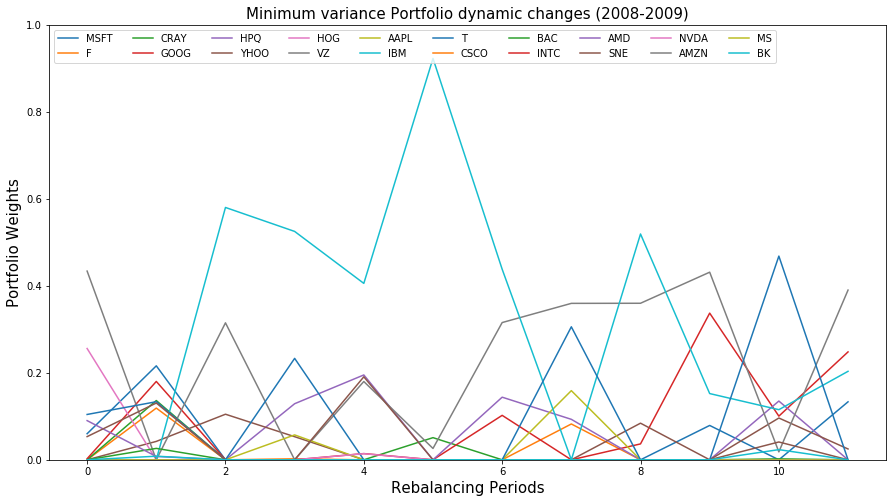

In [31]:
plt.figure(figsize=(15,8))
for i in range(20):
    plt.plot(comp_weights[i*12:(i*12)+12])
plt.xlabel('Rebalancing Periods', fontsize = 15)
plt.ylabel('Portfolio Weights', fontsize = 15)
plt.title('Minimum variance Portfolio dynamic changes (2008-2009)', fontsize = 15)
plt.ylim(0,1)
plt.legend(df.columns[1:],loc=2,ncol=10)
plt.show()

#### Dynamic Plot for Maximum Sharpe ratio Strategy 2008-2009

In [32]:
comp_weights1 = []

for i in range(len(weights[2][1])):
    for j in range(len(weights[2])):
        comp_weights1.append(weights[3][j][i])
        

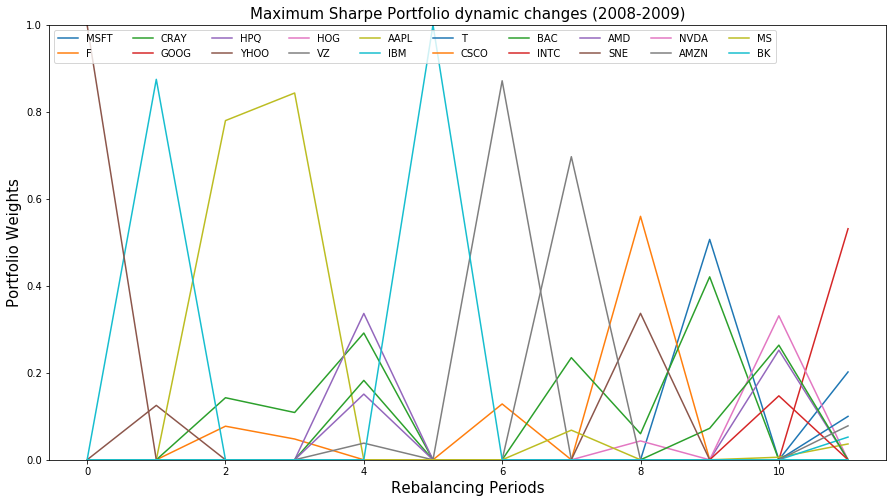

In [33]:
plt.figure(figsize=(15,8))
for i in range(20):
    plt.plot(comp_weights1[i*12:(i*12)+12])
plt.xlabel('Rebalancing Periods', fontsize = 15)
plt.ylabel('Portfolio Weights', fontsize = 15)
plt.title('Maximum Sharpe Portfolio dynamic changes (2008-2009)', fontsize = 15)
plt.ylim(0,1)
plt.legend(df.columns[1:],loc=2,ncol=10)
plt.show()

#### Dynamic Plot for Robust Mean Variance Strategy 2008-2009

In [34]:
comp_weights2 = []

for i in range(len(weights[2][1])):
    for j in range(len(weights[2])):
        comp_weights2.append(weights[6][j][i])
        

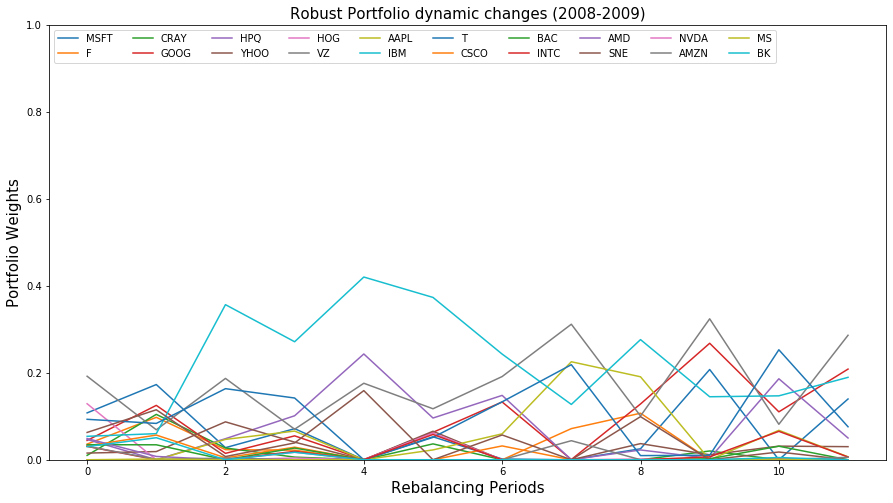

In [35]:
plt.figure(figsize=(15,8))
for i in range(20):
    plt.plot(comp_weights2[i*12:(i*12)+12])
plt.xlabel('Rebalancing Periods', fontsize = 15)
plt.ylabel('Portfolio Weights', fontsize = 15)
plt.title('Robust Portfolio dynamic changes (2008-2009)', fontsize = 15)
plt.ylim(0,1)
plt.legend(df.columns[1:],loc=2,ncol=10)
plt.show()

#### Daily portfolio value for the 3 new strategies 2008-2009

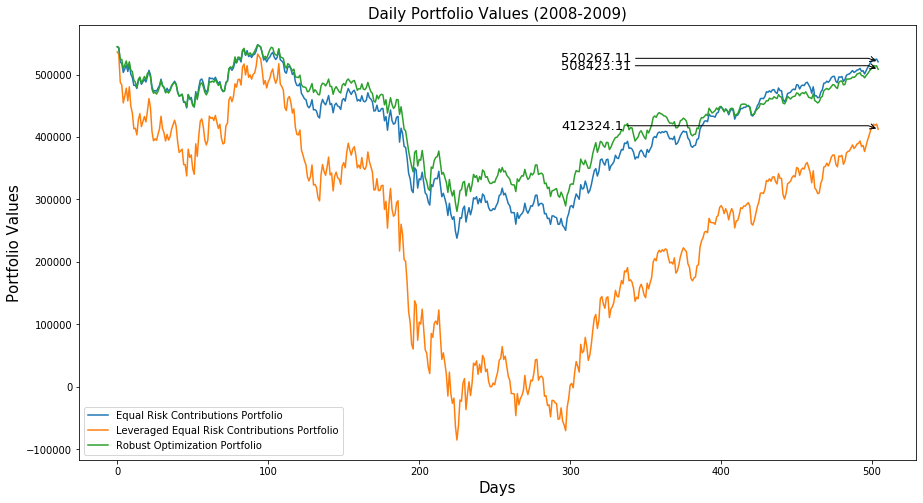

In [36]:
plt.figure(figsize=(15,8))
plt.plot(daily_data.iloc[:, 4:])
plt.xlabel('Days', fontsize = 15)
plt.ylabel('Portfolio Values', fontsize = 15)
plt.title('Daily Portfolio Values (2008-2009)', fontsize = 15)
# plt.ylim(250000,570000)
plt.legend(strategy_names[4:])
for i in range(3):
    y_final = daily_data.iloc[-1,i+4]
    x_pos = 504
    plt.annotate(round(y_final, 2), xy = (x_pos, y_final), xytext = (x_pos-210, y_final+50), arrowprops = dict(arrowstyle = '->', connectionstyle = 'angle, angleA = 0, angleB = -20'), fontsize = 13)
plt.show()

#### Comparision of Daily portfolio value for the 3 new strategies with respect to the previous 4 strategies 2008-2009

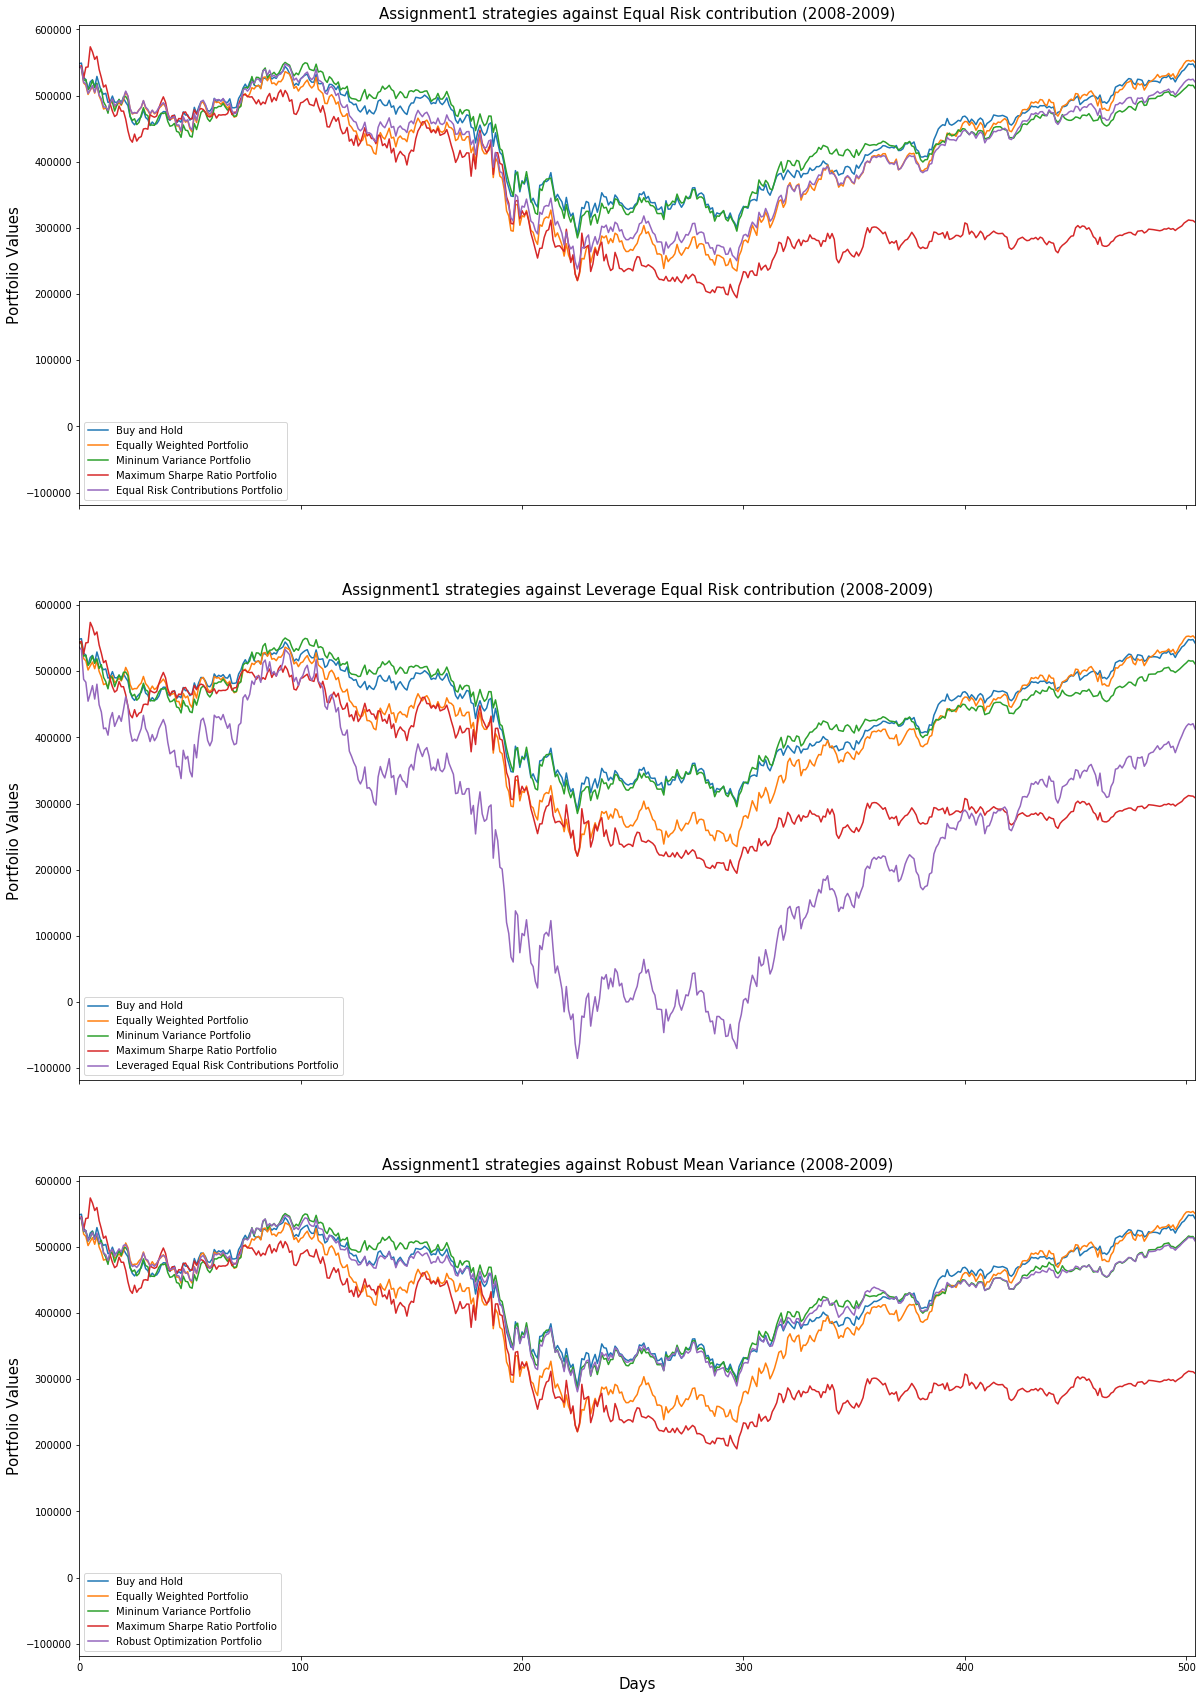

In [37]:
strat = ['Equal Risk Contributions Portfolio', 'Leveraged Equal Risk Contributions Portfolio', 'Robust Optimization Portfolio']
df1 = daily_data.iloc[:, 0:4]
dfs = []
for names in strat:
    df2  = pd.concat([df1, daily_data[names]], axis = 1, sort=False)
    dfs.append(df2)

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(20,30), sharex=True, sharey=True)
dfs[0].plot(ax=ax[0],title='Assignment1 strategies against Equal Risk contribution (2008-2009)')
ax[0].set_ylabel('Portfolio Values', fontsize = 15)
ax[0].title.set_size(15)
dfs[1].plot(ax=ax[1],title='Assignment1 strategies against Leverage Equal Risk contribution (2008-2009)')
ax[1].set_ylabel('Portfolio Values', fontsize = 15)
ax[1].title.set_size(15)
dfs[2].plot(ax=ax[2],title='Assignment1 strategies against Robust Mean Variance (2008-2009)')
ax[2].set_ylabel('Portfolio Values', fontsize = 15)
ax[2].title.set_size(15)
plt.xlabel('Days', fontsize = 15)
# plt.ylim(250000,570000)
plt.show()